---

# **Laboratory 11 Lecture**

## Laboratory 11 - steps:
1. [initializing evironment](#scrollTo=eQBQdjouriT3)
2. [download the dataset](#scrollTo=DylgzscfnMzH)
3. [filter out corrupted images](#scrollTo=vWCjYjWqoXj5)
4. [generate dataset from downloaded data](#scrollTo=fe5q_WtdoyNs)
5. [check and visualize the data](#scrollTo=o2qKr5fLO5b8)
6. [image data augmentation](#scrollTo=zC0oKw7kvqm9)
7. [standardizing the data](#scrollTo=D4tjrYgZyuHV)
8. [configure the dataset for performance](#scrollTo=spLNUAZRKfbp)
9. [build a model](#scrollTo=VGppbeUiLI1z)
10. [compile and train the model](#scrollTo=0qEI3ATA0kBR)
11. [evaluate the model](#scrollTo=o09ILKb800Pq)
12. [test](#scrollTo=yFibsKSqOAgo)
13. [save the Model](#scrollTo=kYQITmbYb0Pd)


---
## 1. Initializing environment
In this lecture, we will use [Tensorflow](https://www.tensorflow.org/) and in particular the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model), that allows to easily create a model from few lines of code. Exploit to the GPU is used to make the training faster.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# The following lines allows to exploit the GPU and make the training faster (Check in the Runtime - Change Runtime time if the GPU is set)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 2. Download the dataset
Let's downlowad the Cats vs Dogs binary classification dataset. At the end, we will have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category.

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  62.6M      0  0:00:12  0:00:12 --:--:-- 46.7M
 CDLA-Permissive-2.0.pdf      PetImages
 kagglecatsanddogs_5340.zip  'readme[1].txt'
Cat  Dog


---
## 3. Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header in this case.

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


---
## 4. Generate dataset from downloaded data

We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility in Keras to generate the training and validation sets from image files in a directory.

In [ ]:
# dimensione delle immagini (già standardizzata)
image_size = (180, 180)

# numero di immagini da inserire nel batch che verranno poi elaborate assieme
batch_size = 128

# creazione del dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# stampa del numero di batch
print("Training set: %d batches" % len(train_ds))
print("Validation set: %d batches" % len(val_ds))


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Training set: 147 batches
Validation set: 37 batches


---
## 5. Check and visualize the data
A batch is made of 128 images 180x180 pixels with 3 channel per pixel (RGB) (exept the last one). To check if a batch has exactly those dimensions we use the ``.shape`` attribute of the batch. We can print out the labes of each image in the batch by simply printing out the batch.

In [ ]:
import numpy as np

# creazione di un iteratore per il train dataset
train_ds_iterator = train_ds.as_numpy_iterator()
batch = train_ds_iterator.next()

# stampa la dimensione del batch 0-esimo (numero_immagini, base_immagine, altezza_immagine, canali_immagine)
print(batch[0].shape)

# stampa l'etichetta di ciascuna immagine del batch 1-esimo (sono 128 etichette)
print(batch[1])

(128, 180, 180, 3)
[1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0
 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0]


To visualize the data on the dataset, we can use [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html). For instance, we plot the 9 images in the training dataset and the corresponding label. As you can see, label 1 is associated with "dog" and label 0 with "cat".

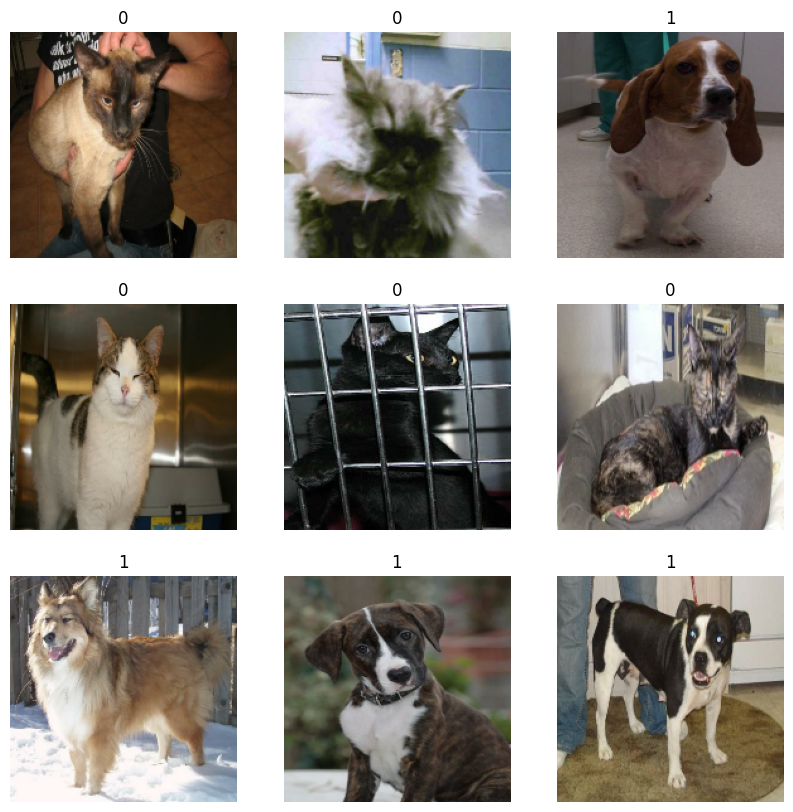

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

---
## 6. Image data augmentation
It's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations for instance. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), # flip orizzontale
                                      layers.RandomRotation(0.1)]) # rotazione random

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

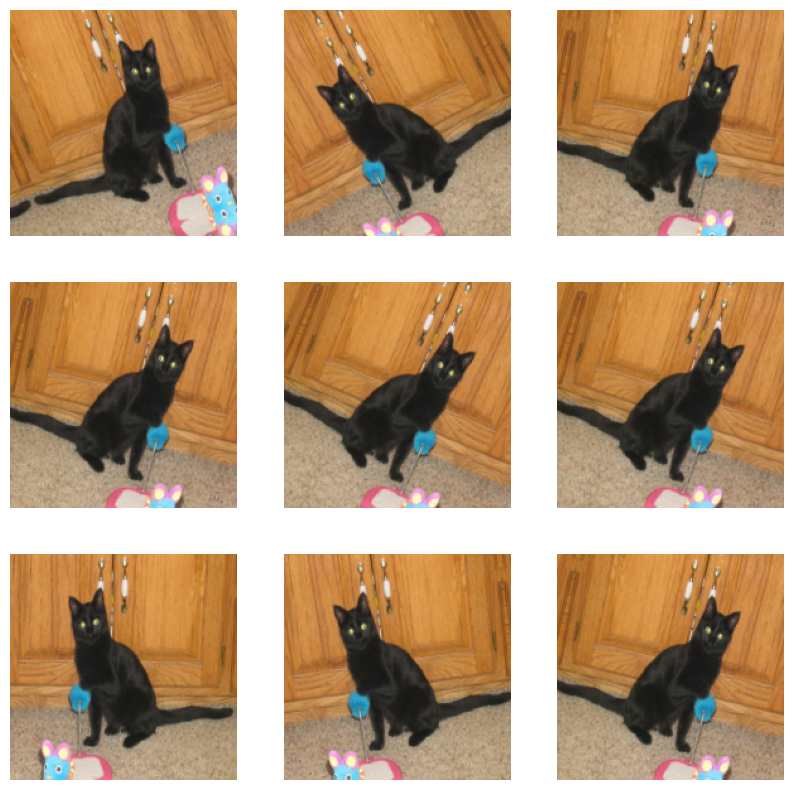

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

---
## 7. Standardizing the data
The images that we are using are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [ ]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))
print(train_ds.as_numpy_iterator().next()[0].min()) # we check for instance the min
print(train_ds.as_numpy_iterator().next()[0].max()) # we check for instance the max

0.0
1.0


---
## 8. Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` and standardization to the training images.
train_ds = train_ds.map(    # apply a sort of transformation, it is quick
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
print(train_ds.as_numpy_iterator().next()[0].max())
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

1.0


---
## 9. Build a model

Create the convolutional base. The lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (180, 180, 1). You can do this by passing the argument input_shape to your first layer.

In [ ]:
from tensorflow.keras import models
model = models.Sequential() # Sequential you have one input and one output as in this case

# There are some hyperparameters in the architecture. According to these, the performance of the architecture can change

# 1° convolutional layer sequentially with this parameters:
# - number of filters -> 16
# - dimension of filters -> 3x3
# - stride in pixels -> 1 pixel
# - activation function -> relu
# - input shape (ignoring batch size)
model.add(layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(180, 180, 3)))

# 1° pooling layer
# go the max in the region and condense this information down, the region size is 2x2
model.add(layers.MaxPooling2D((2, 2)))

# 2° convolutional layer
model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# 2° pooling layer
model.add(layers.MaxPooling2D((2, 2)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Add Dense layers on top to complete the model, you will feed the last output tensor from the convolutional base into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top.

In [ ]:
# flatten layer from 3D to 1D
model.add(layers.Flatten())

# first neuron layer, first parameter is the number of neurons
model.add(layers.Dense(64, activation='relu'))

# second neuron layer with only one neuron to get just one output: if 0 corresponds to class 0, if 1 to class 1
model.add(layers.Dense(1, activation='sigmoid'))

Let's display the architecture of your model so far:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 29584)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,893,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,896,273 (7.23 MB)

 Trainable params: 1,896,273 (7.23 MB)

 Non-trainable params: 0 (0.00 B)

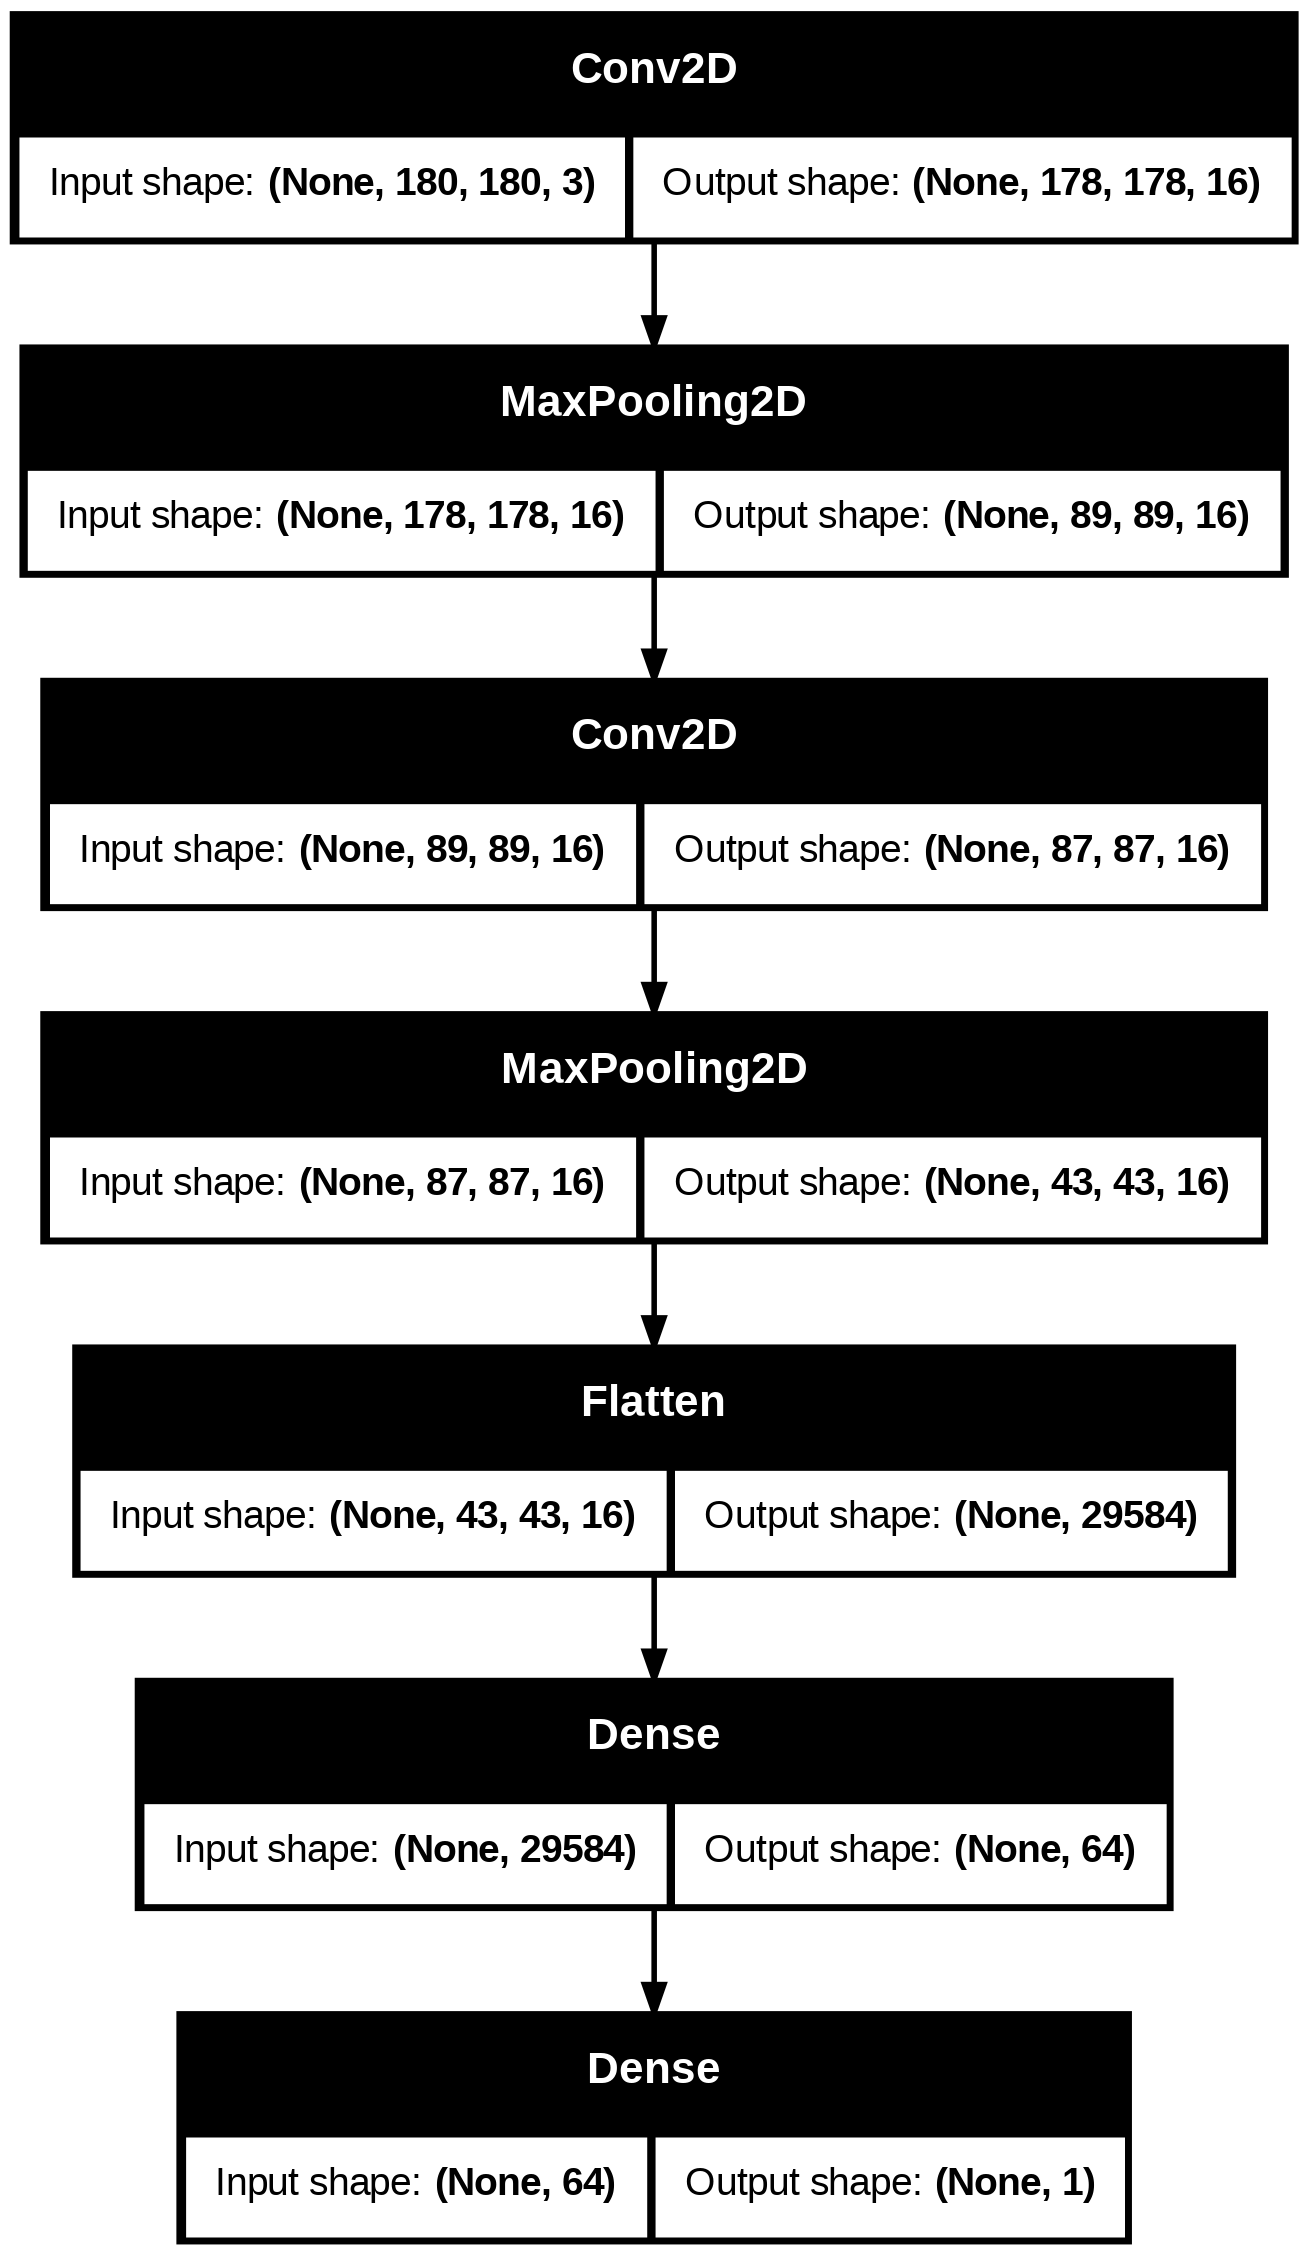

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

---
## 10. Compile and train the model

In [ ]:
epochs = 5 # for timing constraints, a common number for instance is 20-25
model.compile( # this is very important, define the optimizer, the loss and the metrics to track
    optimizer=keras.optimizers.Adam(1e-3), # for regularization
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

logdir='logs' # 1.02
# callback allows to create the checkpoint to check the log, to save a tmp model, to see how your model is performing
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# fit the data, we save the output in hist in order to retrieve the information about the training of the model
hist = model.fit(
    train_ds, # training data
    epochs=epochs, # how long to train
    validation_data=val_ds, # we pass then the validation, we can see how the model performs in real time
    callbacks=[tensorboard_callback] # pass the callback for the checkpoint
)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 102s 637ms/step - accuracy: 0.5594 - loss: 0.7164 - val_accuracy: 0.7082 - val_loss: 0.5624
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 102s 687ms/step - accuracy: 0.6984 - loss: 0.5764 - val_accuracy: 0.7317 - val_loss: 0.5232
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 101s 688ms/step - accuracy: 0.7265 - loss: 0.5369 - val_accuracy: 0.7394 - val_loss: 0.5144
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 622ms/step - accuracy: 0.7428 - loss: 0.5153 - val_accuracy: 0.7565 - val_loss: 0.4977
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 606ms/step - accuracy: 0.7550 - loss: 0.4977 - val_accuracy: 0.7572 - val_loss: 0.4990


NB: The loss is decreasing and the accuracy is increasing epoch by epoch

You can retrieve some information about the training

In [ ]:
hist.history

{'accuracy': [0.612718939781189,
  0.7120354771614075,
  0.727680504322052,
  0.747276782989502,
  0.7571550607681274],
 'loss': [0.6577210426330566,
  0.5623643398284912,
  0.5333732962608337,
  0.5103121995925903,
  0.49340012669563293],
 'val_accuracy': [0.7082443237304688,
  0.7317385673522949,
  0.7394275665283203,
  0.756514310836792,
  0.7571550607681274],
 'val_loss': [0.5624029636383057,
  0.5232247114181519,
  0.5144242644309998,
  0.49769777059555054,
  0.49896061420440674]}

---
## 11. Evaluate the model

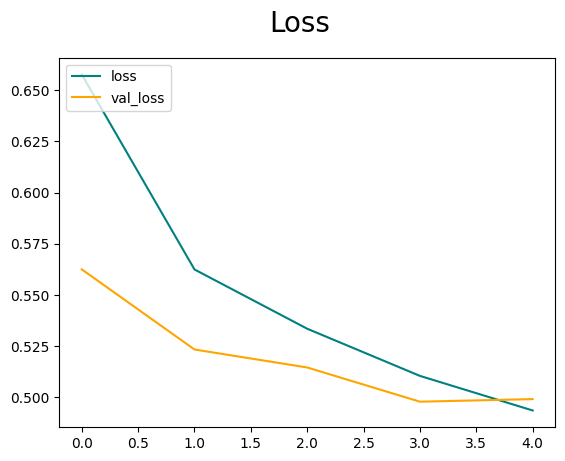

In [ ]:
# plot of the loss and val_loss functions for every epoch
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

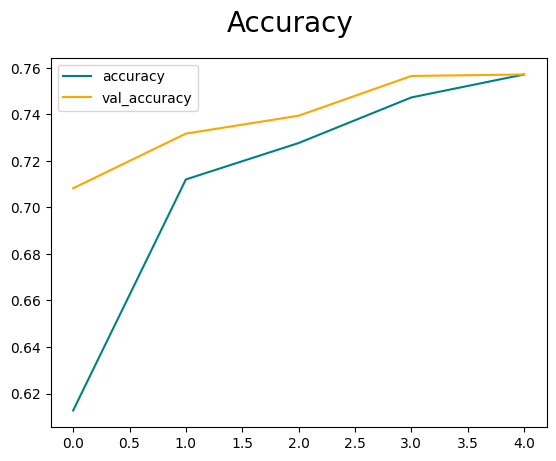

In [ ]:
# plot of the accuracy and val_accuracy functions for every epoch
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

---
## 12. Test
Test the model with new images

In [ ]:
!pip install gdown

Downloading...
From: https://drive.google.com/uc?id=1WTXIeWjoXwDgw2NGygAe11TRHpz4Y0cT
To: /content/img0.jpg
100%|██████████| 1.25M/1.25M [00:00<00:00, 62.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GlYCU3N4WqqIrIcC9V_1EtjNOYijWUsW
To: /content/img1.jpg
100%|██████████| 87.5k/87.5k [00:00<00:00, 24.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G7pq3gDj8X0YZbzkjigImLmtO6cUFs80
To: /content/img2.jpg
100%|██████████| 84.5k/84.5k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nTjgZg8SwyHiXr1F1cKqLtVygaZoluq3
To: /content/img3.jpg
100%|██████████| 134k/134k [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IXVVVbCKAAKfwTeSW6EKD439VZwiLQ-N
To: /content/img4.jpg
100%|██████████| 1.50M/1.50M [00:00<00:00, 137MB/s]


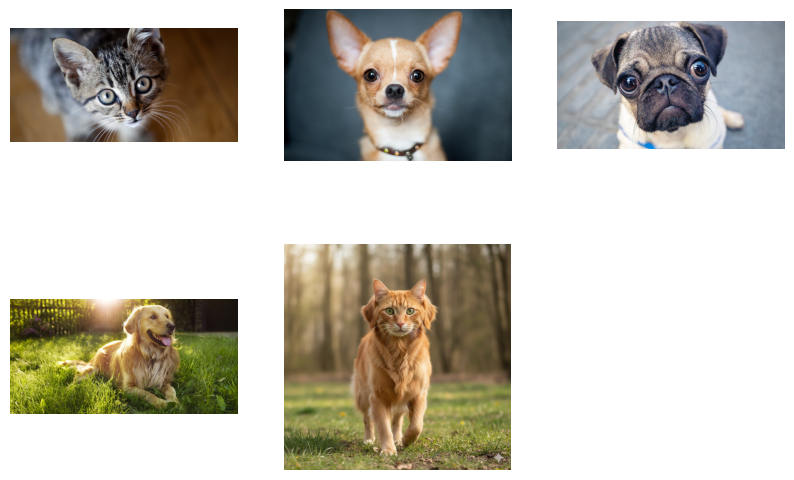

In [ ]:
import gdown
import cv2

# url of the new images
img_url = ["https://drive.google.com/uc?id=1WTXIeWjoXwDgw2NGygAe11TRHpz4Y0cT", #cat
           "https://drive.google.com/uc?id=1GlYCU3N4WqqIrIcC9V_1EtjNOYijWUsW", #dog
           "https://drive.google.com/uc?id=1G7pq3gDj8X0YZbzkjigImLmtO6cUFs80", #dog
           "https://drive.google.com/uc?id=1nTjgZg8SwyHiXr1F1cKqLtVygaZoluq3", # dog
           "https://drive.google.com/uc?id=1IXVVVbCKAAKfwTeSW6EKD439VZwiLQ-N"] # hybrid

# list of the color-corrected images
rgb_img = []

for url, i in zip(img_url, range(len(img_url))):
    output = "/content/img" + str(i) + ".jpg"  # Output path for the downloaded image from Google drive
    gdown.download(url, output, quiet=False)
    img = cv2.imread(output, cv2.IMREAD_COLOR)
    rgb_img.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # to adjust the color

plt.figure(figsize=(10, 10))
for img, i in zip(rgb_img, range(len(rgb_img))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.show()

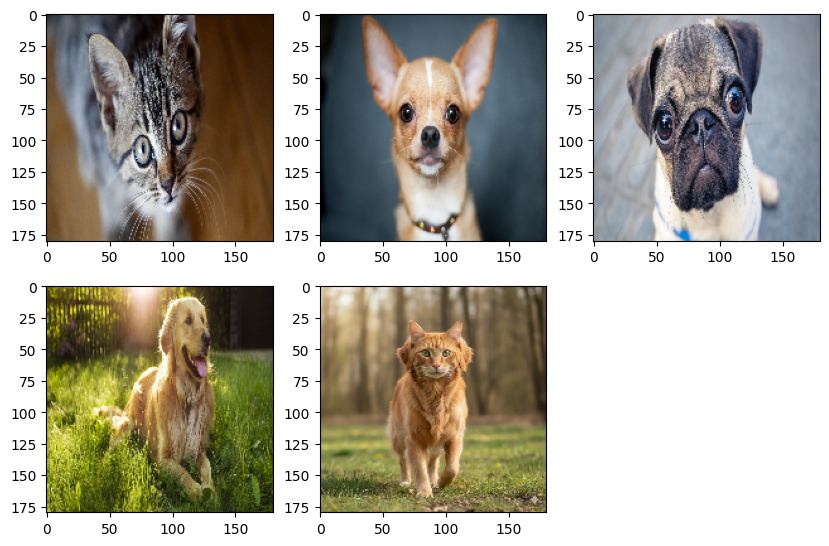

In [ ]:
# lista delle immagini ridinensionate per l'elaborazione
resize_img = []

# ridimensionamento immagine
for img in rgb_img:
    resize_img.append(tf.image.resize(img, image_size))

# stampa immagini ridimensionate
plt.figure(figsize=(10, 10))
for img, i in zip(resize_img, range(len(resize_img))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype(int))
plt.show()

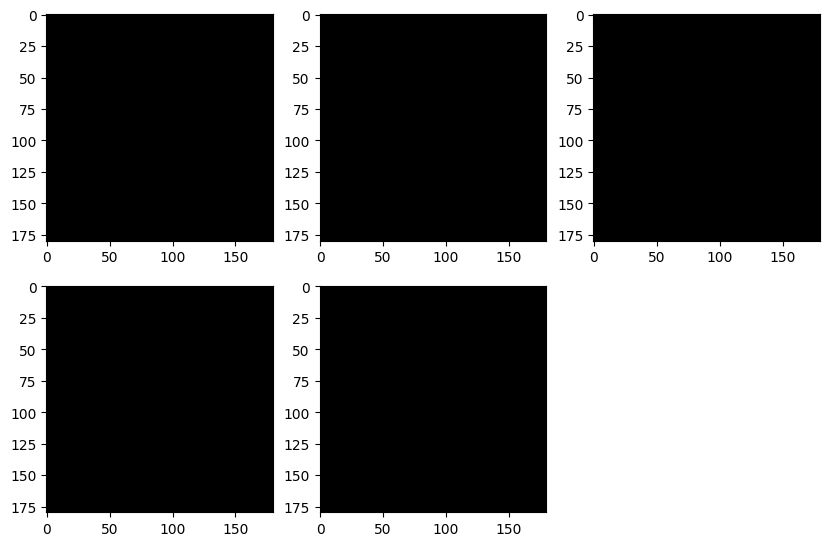

In [ ]:
# lista delle immagini color-normalized
norm_img = []

# color normalization immagine
for img in resize_img:
    norm_img.append(np.expand_dims(img/255, 0))

# stampa immagini color-nomalized (saranno tutte nere)
plt.figure(figsize=(10, 10))
for img, i in zip(norm_img, range(len(norm_img))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.reshape(180,180,3).astype(int))
plt.show()

In [ ]:
# calcolo predizioni
yhat = []
for img in norm_img:
    yhat.append(model.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [ ]:
# stampa predizioni
for prediction in yhat:
    if prediction > 0.5:  # this happens in binary classification
        print(f'Predicted class is Dog with value:', prediction)
    else:
        print(f'Predicted class is Cat with value:', prediction)

Predicted class is Cat with value: [[0.4078585]]
Predicted class is Cat with value: [[0.4466495]]
Predicted class is Dog with value: [[0.6082531]]
Predicted class is Dog with value: [[0.9803412]]
Predicted class is Dog with value: [[0.9412512]]


---
## 13. Save the Model

In [ ]:
from tensorflow.keras.models import load_model # to save and load then the model

In [ ]:
# salvataggio del modello
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
# caricamento del modello appena salvato
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
# verifica che del modello salvato
for img in norm_img:
    yhat1 = new_model.predict(img)
    yhat2 = model.predict(img)
    if yhat1 > 0.5:  # this happens in binary classification
        print(f'model_1 predicted class is Dog with value:', yhat1)
    else:
        print(f'model_1 predicted class is Cat with value:', yhat1)
    if yhat2 > 0.5:  # this happens in binary classification
        print(f'model_1 predicted class is Dog with value:', yhat2)
    else:
        print(f'model_1 predicted class is Cat with value:', yhat2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
model_1 predicted class is Cat with value: [[0.4078585]]
model_1 predicted class is Cat with value: [[0.4078585]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
model_1 predicted class is Cat with value: [[0.4466495]]
model_1 predicted class is Cat with value: [[0.4466495]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
model_1 predicted class is Dog with value: [[0.6082531]]
model_1 predicted class is Dog with value: [[0.6082531]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
model_1 predicted class is Dog with value: [[0.9803412]]
model_1 predicted class is Dog with value: [[0.9803412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
model_1 predicted class is Dog with value: [[0.9412512]]
model_1 predicted class is Dog with value: [[0.9412512]]
